# Loading Packages

In [1]:
import Pkg
Pkg.activate("./dibs_env")

install_run = false
if install_run
    ENV["PYTHON"]=""
    Pkg.instantiate()
    using Conda
    Conda.add("dustmaps")
#     Pkg.add(["Glob","FITSIO","Serialization", "HDF5", "DelimitedFiles"])
#     Pkg.add(["StatsBase","Distributions","FreqTables", "LsqFit"])
#     Pkg.add(["BinnedStatistics","KrylovKit","ImageTransformations"])
#     Pkg.add(["DataFrames", "ProgressMeter", "Distributed", "BenchmarkTools"])
#     Pkg.add(["Healpix", "SkyCoords", "WCS"])
#     Pkg.add(["LaTeXStrings", "Formatting", "Printf", "PyFormattedStrings"])
#     Pkg.add(["Conda","PyCall","PyPlot
end

#File Handling
using Glob, FITSIO, Serialization, HDF5, DelimitedFiles
# Stats
using StatsBase, LinearAlgebra, Distributions, FreqTables, LsqFit 
using BinnedStatistics, KrylovKit, ImageTransformations
# Computing
using DataFrames, ProgressMeter, Distributed, BenchmarkTools, Random
# Astro
using Healpix, SkyCoords, WCS
# Python Plotting Setup
using PyCall, LaTeXStrings, Formatting, Printf, PyFormattedStrings
import PyPlot; const plt = PyPlot
mpltk=pyimport("mpl_toolkits.axes_grid1")
patches=pyimport("matplotlib.patches")
mplcolors=pyimport("matplotlib.colors")
mplani = pyimport("matplotlib.animation");
cc=pyimport("colorcet")
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);
py"""
from scipy.stats import binned_statistic_2d
"""

if install_run
    py"""
    from dustmaps.config import config
    config.reset()
    """
end
plt.matplotlib.style.use("dark_background")

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/zenodo/GaiaDIB/notebooks/dibs_env`


# Work Up Production Run

In [3]:
foldname="out/prod"
xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0
cwave = 8623.14
cgrid = 8623.54;
cwave_cent = 8623.47
mu1 = cwave_cent;
dwav = 40;

srng = -100:0.1:100
sigrng = 0.4:0.01:4;

In [ ]:
wu_from_scratch = false
if wu_from_scratch
    deblendf = glob("*.h5","../$foldname"*"_out");
    batsz = 40
    println(length(deblendf))

    grvs = h5open("../sources/gaia_rvs_lite.h5");
    nsamp = length(grvs["SOURCE_ID"])
    μ_cd0lst = zeros(length(wavex),batsz*length(deblendf))
    μ_bd0lst = zeros(length(wavex),batsz*length(deblendf))
    μ_cdlst = zeros(length(wavex),batsz*length(deblendf))
    μ_bdlst = zeros(length(wavex),batsz*length(deblendf))
    μ_ddlst = zeros(length(wavex),batsz*length(deblendf))
    locGridlst = zeros(3,11,3,batsz*length(deblendf))
    μ_chi2srgh = zeros(length(1:10:length(srng)),batsz*length(deblendf))
    μ_chi2sigrgh = zeros(length(1:2:length(sigrng)),batsz*length(deblendf))
    μ_chi2sfine = zeros(length(-180:180),batsz*length(deblendf))
    μ_chi2sigfine = zeros(length(-90:90),batsz*length(deblendf))
    μ_outlst = zeros(23,batsz*length(deblendf))
    @showprogress for (i,ival) in enumerate(1:batsz:nsamp)
        f = h5open(deblendf[i])
        μ_cd0lst[:,ival:(ival+batsz-1)] .= read(f["μ_cd0"])
        μ_bd0lst[:,ival:(ival+batsz-1)] .= read(f["μ_bd0"])

        μ_cdlst[:,ival:(ival+batsz-1)] .= read(f["μ_cd"])
        μ_bdlst[:,ival:(ival+batsz-1)] .= read(f["μ_bd"])
        μ_ddlst[:,ival:(ival+batsz-1)] .= read(f["μ_dd"])
        μ_outlst[:,ival:(ival+batsz-1)] .= read(f["outlst"])
        μ_chi2srgh[:,ival:(ival+batsz-1)] .= read(f["chi2srgh"])
        μ_chi2sigrgh[:,ival:(ival+batsz-1)] .= read(f["chi2sigrgh"])
        μ_chi2sfine[:,ival:(ival+batsz-1)] .= read(f["chi2sfine"])
        μ_chi2sigfine[:,ival:(ival+batsz-1)] .= read(f["chi2sigfine"])
        locGridlst[:,:,:,ival:(ival+batsz-1)] .= read(f["locGrid"])
        close(f)
    end
    μ_cd0_mat = view(μ_cd0lst,:,1:nsamp);
    μ_bd0_mat = view(μ_bd0lst,:,1:nsamp);

    μ_cd_mat = view(μ_cdlst,:,1:nsamp);
    μ_bd_mat = view(μ_bdlst,:,1:nsamp);
    μ_dd_mat = view(μ_ddlst,:,1:nsamp);
    μ_chi2srgh_mat = view(μ_chi2srgh,:,1:nsamp);
    μ_chi2sigrgh_mat = view(μ_chi2sigrgh,:,1:nsamp);
    μ_chi2sfine_mat = view(μ_chi2sfine,:,1:nsamp);
    μ_chi2sigfine_mat = view(μ_chi2sigfine,:,1:nsamp);
    μ_out_mat = view(μ_outlst,:,1:nsamp);
    locGridlst_mat = view(locGridlst,:,:,:,1:nsamp);

    h5write("../$foldname"*"_wu/scan_μ_cd0.h5","μ_cd0",μ_cd0_mat)
    h5write("../$foldname"*"_wu/scan_μ_bd0.h5","μ_bd0",μ_bd0_mat)

    h5write("../$foldname"*"_wu/scan_μ_cd.h5","μ_cd",μ_cd_mat)
    h5write("../$foldname"*"_wu/scan_μ_bd.h5","μ_bd",μ_bd_mat)
    h5write("../$foldname"*"_wu/scan_μ_dd.h5","μ_dd",μ_dd_mat)
    h5write("../$foldname"*"_wu/scan_out.h5","out",μ_out_mat)
    h5write("../$foldname"*"_wu/scan_chi2srgh.h5","chi2srgh",μ_chi2srgh_mat)
    h5write("../$foldname"*"_wu/scan_chi2sigrgh.h5","chi2sigrgh",μ_chi2sigrgh_mat)
    h5write("../$foldname"*"_wu/scan_chi2sfine.h5","chi2sfine",μ_chi2sfine_mat)
    h5write("../$foldname"*"_wu/scan_chi2sigfine.h5","chi2sigfine",μ_chi2sigfine_mat)
    h5write("../$foldname"*"_wu/scan_locGrid.h5","locGrid",locGridlst_mat);
end

In [7]:
if wu_from_scratch
    addprocs(32);
    @everywhere begin
        import Pkg
        Pkg.activate("./dibs_env")
        using LsqFit, HDF5, ProgressMeter, Random
        
        foldname="out/prod"

        xmin0 = 8460
        xmax0 = 8700
        wavex = xmin0:0.1:xmax0
        cgrid = 8623.54;
        dwav = 40;
        cwave_cent = 8623.47

        grvs = h5open("../sources/gaia_rvs_lite.h5");
        nsamp = length(grvs["SOURCE_ID"])
        dwav = 51
        lsqmsk = (cgrid-dwav) .<wavex .<(cgrid+dwav);
        dwav=40
        minlsqmsk = minimum(wavex[lsqmsk])
        maxlsqmsk = maximum(wavex[lsqmsk]);

        μ_bd_mat = h5open("../$foldname"*"_wu/scan_μ_bd.h5")
        μ_dd_mat = h5open("../$foldname"*"_wu/scan_μ_dd.h5");
        sout_mat = h5open("../$foldname"*"_wu/scan_out.h5");

        function compute_bestfit(ind)
            μ_bd = μ_bd_mat["μ_bd"][:,ind];
            μ_dd = μ_dd_mat["μ_dd"][:,ind];
            sout = sout_mat["out"][:,ind];
            y=μ_dd[lsqmsk]./μ_bd[lsqmsk]
            lower = [-Inf,minlsqmsk,0.1]
            upper = [Inf,maxlsqmsk,Inf]
            absamp, aind = findmax(abs.(y))
            amp0 = y[aind]*sqrt(2*pi)
            rng = MersenneTwister(ind)
            n1 = 0.01*randn(rng)
            n2 = 0.01*randn(rng)

            p0 = [amp0,cwave_cent.-0.1 .*sout[11] + n1,sout[12] + n2]
            @. gfit(x, p) = p[1] .* exp.(-0.5 .*((x.-p[2])./p[3]).^2)./(sqrt(2*pi))

            try
                fit = LsqFit.curve_fit(
                    gfit, 
                    wavex[lsqmsk], 
                    y, 
                    p0, 
                    lower=lower, 
                    upper=upper
                )
                return fit.param
            catch 
                return [NaN, NaN, NaN]
            end
        end
    end
end

      From worker 2:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 3:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 4:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 5:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 6:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 8:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 9:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`
      From worker 10:	  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/julia_env/dibs`


In [8]:
if wu_from_scratch
    pout = @showprogress pmap(compute_bestfit,1:nsamp)
    t_out = hcat(pout...);
    h5write("../$foldname"*"_wu/t_out.h5","t_out",t_out);
    rmprocs(procs())
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:224:00


# Analyze

In [4]:
sout_mat = h5read("../$foldname"*"_wu/scan_out.h5","out");
t_out = h5read("../$foldname"*"_wu/t_out.h5","t_out");

In [5]:
noisefact = 3.6;

In [6]:
covdet = h5read("../priors/precomp_dust_2_analyticDeriv.h5","covdet")
covdet0 = median(covdet)

-13.363927852674818

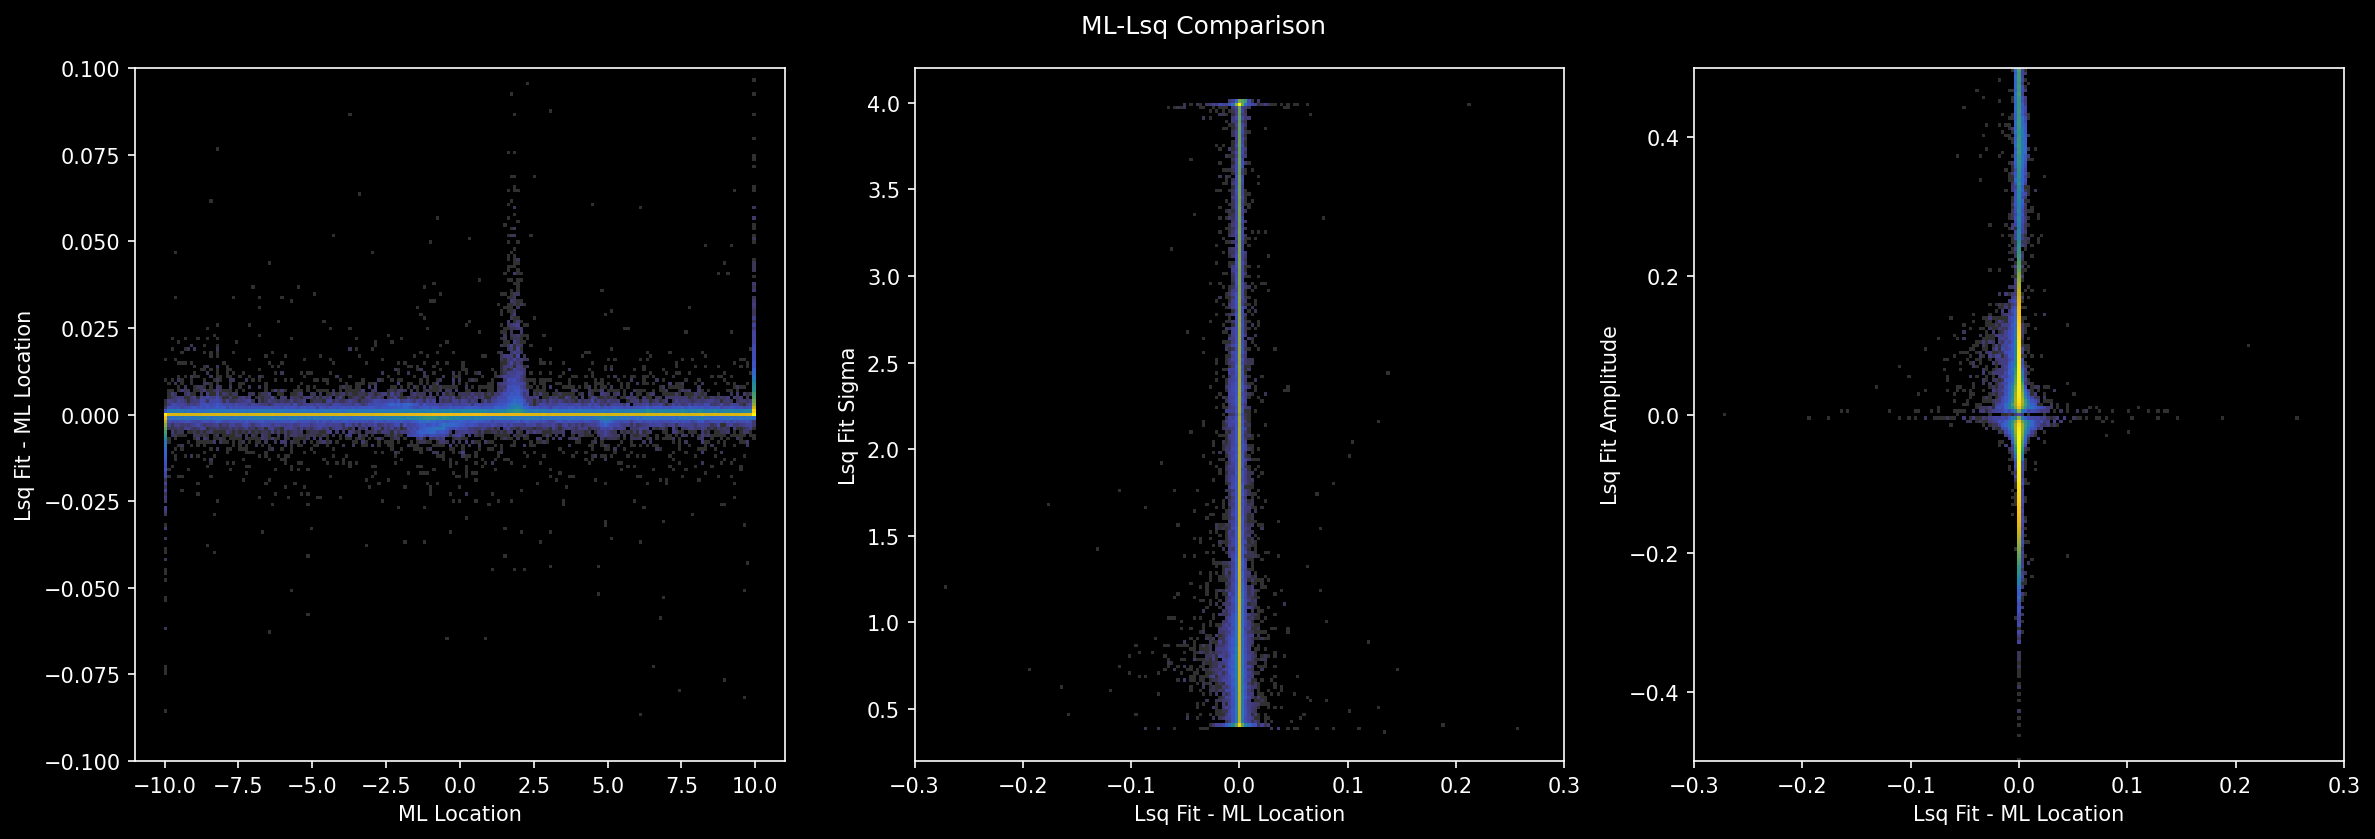

In [7]:
fig = plt.figure(figsize=(19,6),dpi=150)
plt.suptitle("ML-Lsq Comparison",y=0.94)
dwav=11
ax = fig.add_subplot(1,3,1)
nbin=201
ax.hist2d(-0.1 .*sout_mat[11,:],
    t_out[2,:].-(mu1.-0.1 .*sout_mat[11,:]),
    bins=(nbin,nbin),
    range=((-dwav,dwav),(-0.1,0.1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-dwav,dwav)
ax.set_ylim(-0.1,0.1)
dwav=40

ax.set_xlabel("ML Location")
ax.set_ylabel("Lsq Fit - ML Location")


ax = fig.add_subplot(1,3,2)
nbin=201
ax.hist2d(mu1.-0.1 .*sout_mat[11,:].-t_out[2,:],t_out[3,:],
    bins=(nbin,nbin),
    range=((-0.3,0.3),(0.2,4.2)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-0.3,0.3)
ax.set_ylim(0.2,4.2)

ax.set_ylabel("Lsq Fit Sigma")
ax.set_xlabel("Lsq Fit - ML Location")


ax = fig.add_subplot(1,3,3)
nbin=201
ax.hist2d(mu1.-0.1 .*sout_mat[11,:].-t_out[2,:],t_out[1,:],
    bins=(nbin,nbin),
    range=((-0.3,0.3),(-0.5,0.5)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.5,0.5)

ax.set_ylabel("Lsq Fit Amplitude")
ax.set_xlabel("Lsq Fit - ML Location");

In [8]:
star_msk, nansum = deserialize("../priors/star_mask.jdat");
SNR_lst = h5read("../priors/SNR_lst.h5","SNR_lst");

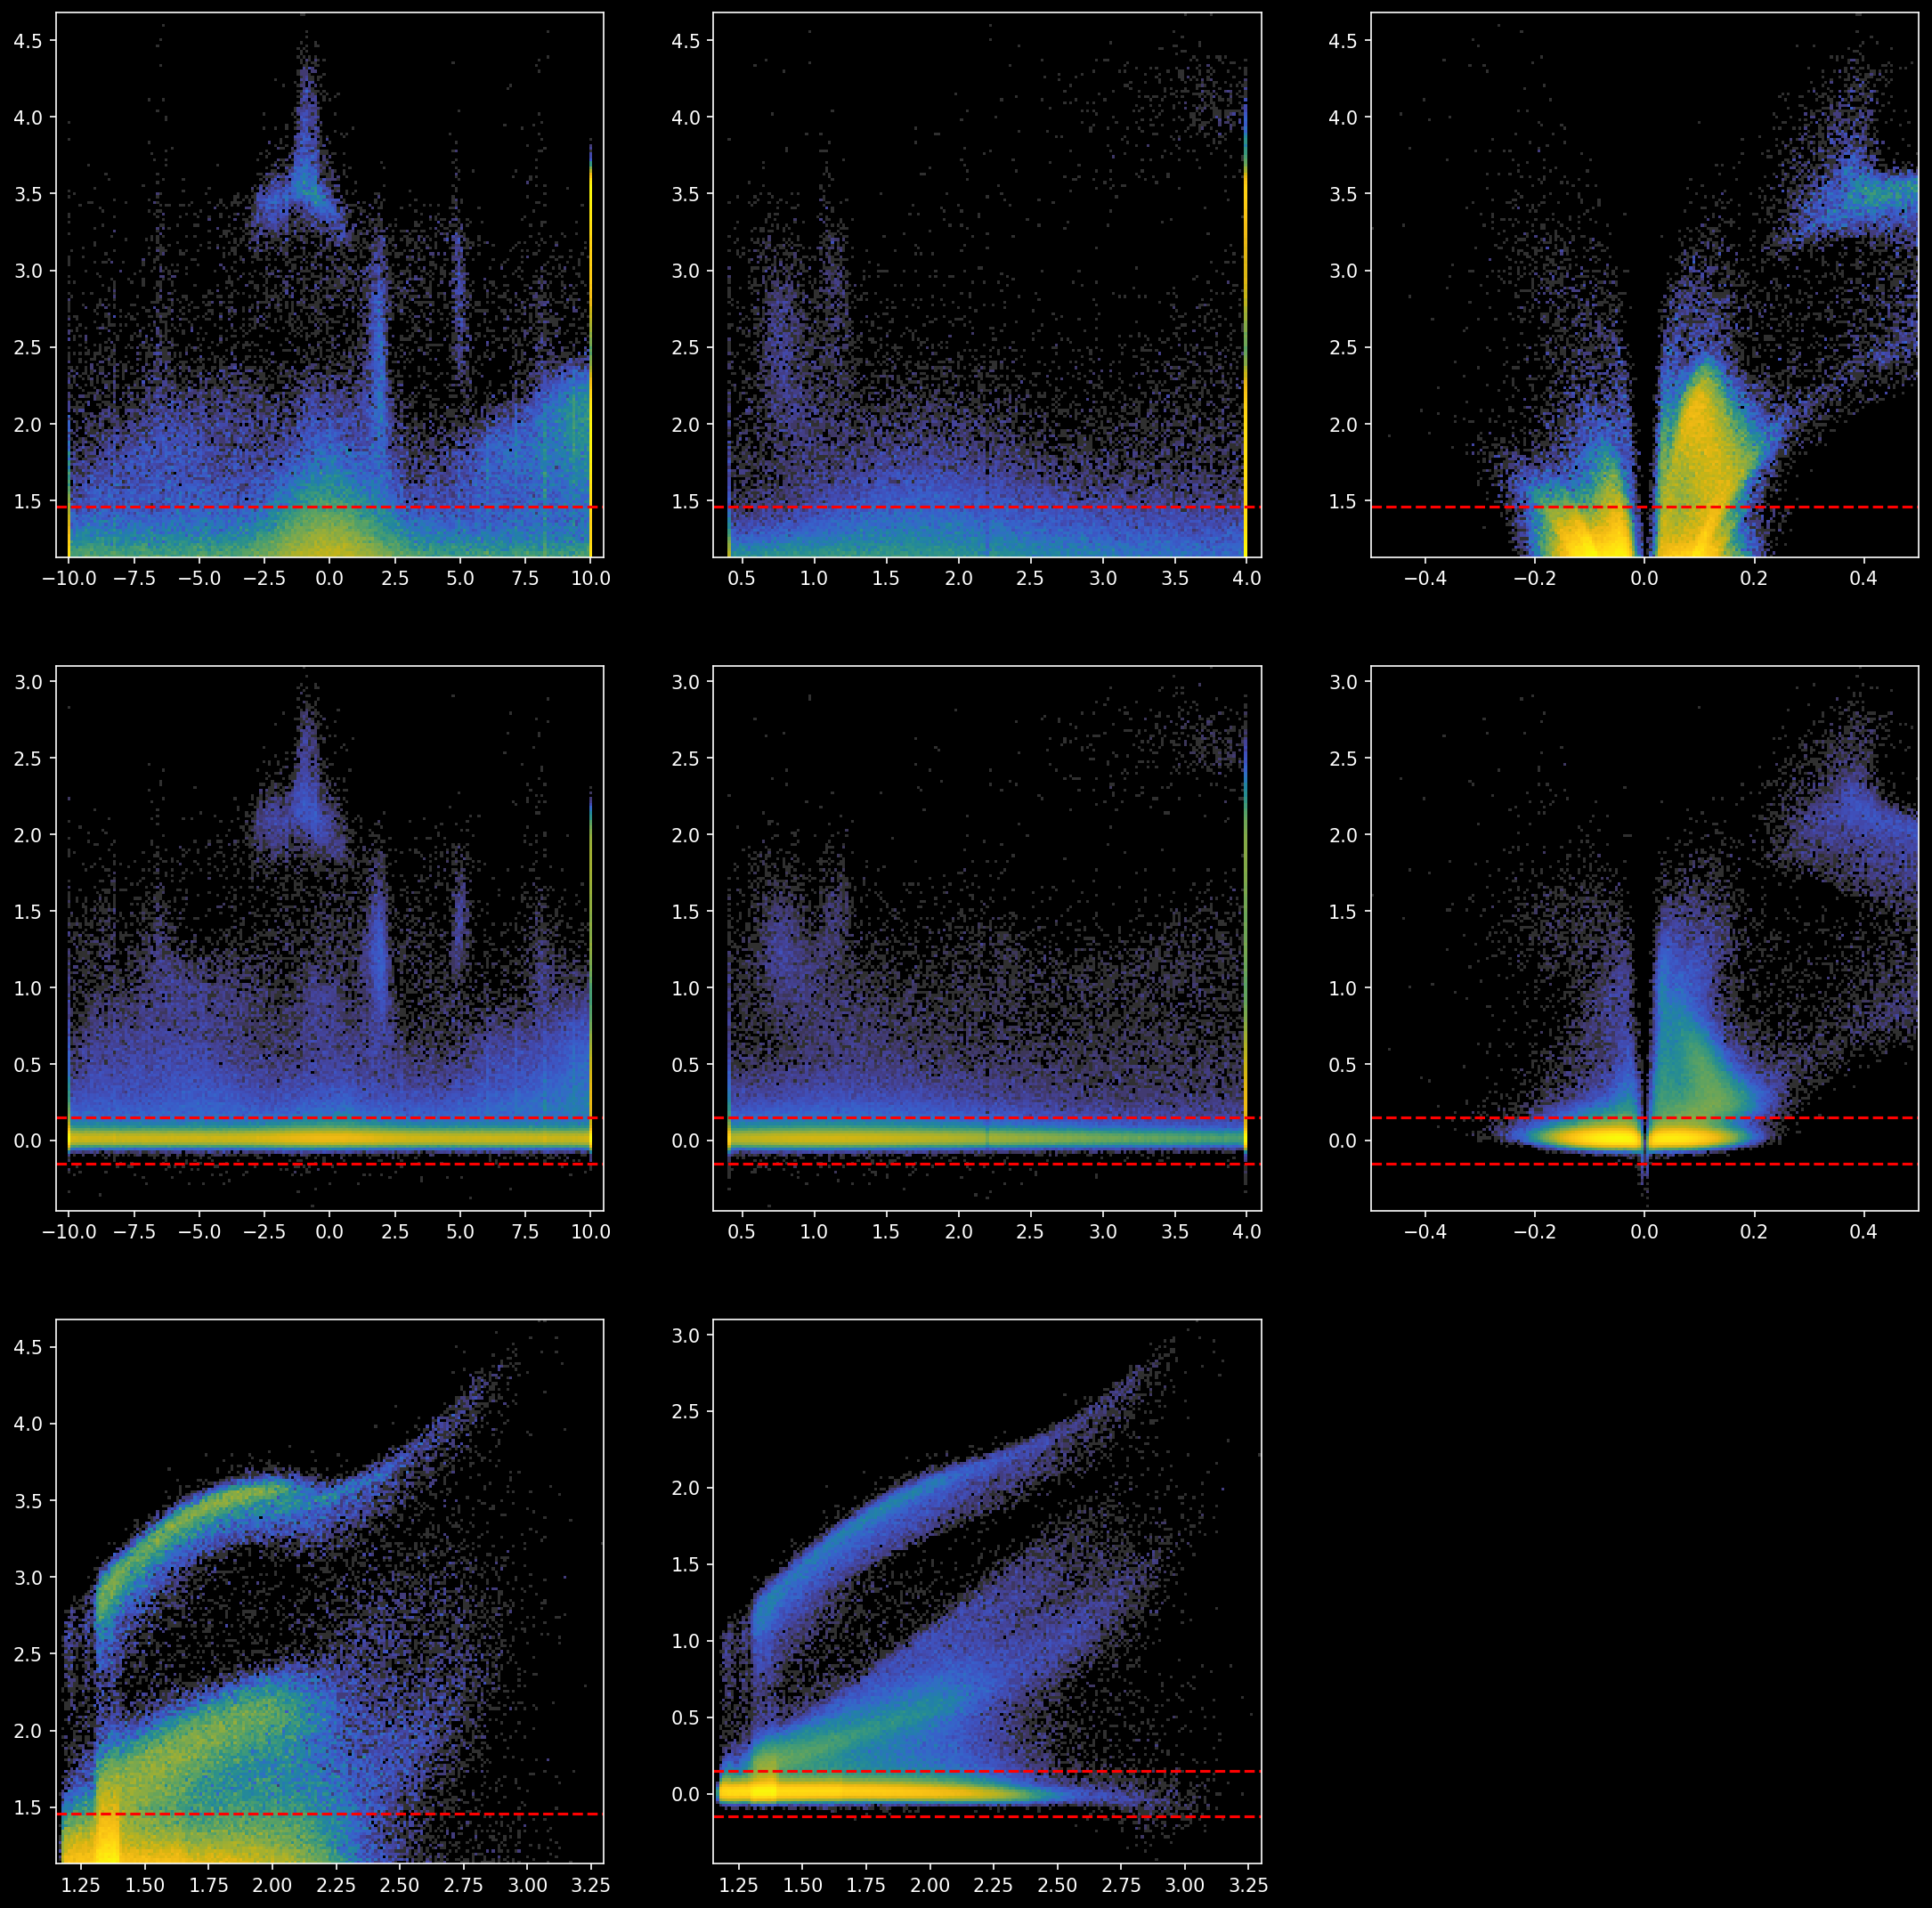

PyObject <matplotlib.lines.Line2D object at 0x14a6fd30ea90>

In [10]:
delthres = 1.46

mint = minimum(filter(.!isnan,log10.(-sout_mat[9,:])))
maxt = maximum(filter(.!isnan,log10.(-sout_mat[9,:])))

fig = plt.figure(figsize=(18,18),dpi=150)
nbin = 191
ax = fig.add_subplot(3,3,1)
ax.hist2d(
    (-0.1 .*sout_mat[11,:]),
    log10.(-sout_mat[9,:].+covdet0),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,2)
ax.hist2d(
    sout_mat[12,:],
    log10.(-sout_mat[9,:].+covdet0),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,3)
ax.hist2d(
    t_out[1,:],
    log10.(-sout_mat[9,:].+covdet0),
    bins=(nbin,nbin),
    cmap="cet_gouldian",
    range=((-0.5,0.5),(mint,maxt)),
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

chi2perdof  = 0.15

mint1 = minimum(filter(.!isnan,(log10.(3.33*sout_mat[15,:]./count(star_msk)))))
maxt1 = maximum(filter(.!isnan,(log10.(3.33*sout_mat[15,:]./count(star_msk)))))

ax = fig.add_subplot(3,3,4)
ax.hist2d(
    (-0.1 .*sout_mat[11,:]),
    (log10.(noisefact*sout_mat[15,:]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,5)
ax.hist2d(
    sout_mat[12,:],
    (log10.(noisefact*sout_mat[15,:]./count(star_msk))),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,6)
ax.hist2d(
    t_out[1,:],
    (log10.(noisefact*sout_mat[15,:]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-0.5,0.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")


ax = fig.add_subplot(3,3,7)
ax.hist2d(
    log10.(SNR_lst),
    log10.(-sout_mat[9,:].+covdet0),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,8)
ax.hist2d(
    log10.(SNR_lst),
    (log10.(noisefact*sout_mat[15,:]./count(star_msk))),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

In [37]:
msk5 = (-chi2perdof .< (log10.(noisefact*sout_mat[15,:]./count(star_msk))).<chi2perdof)
count(msk5), count(msk5)/length(msk5)

(864528, 0.8648350164308329)

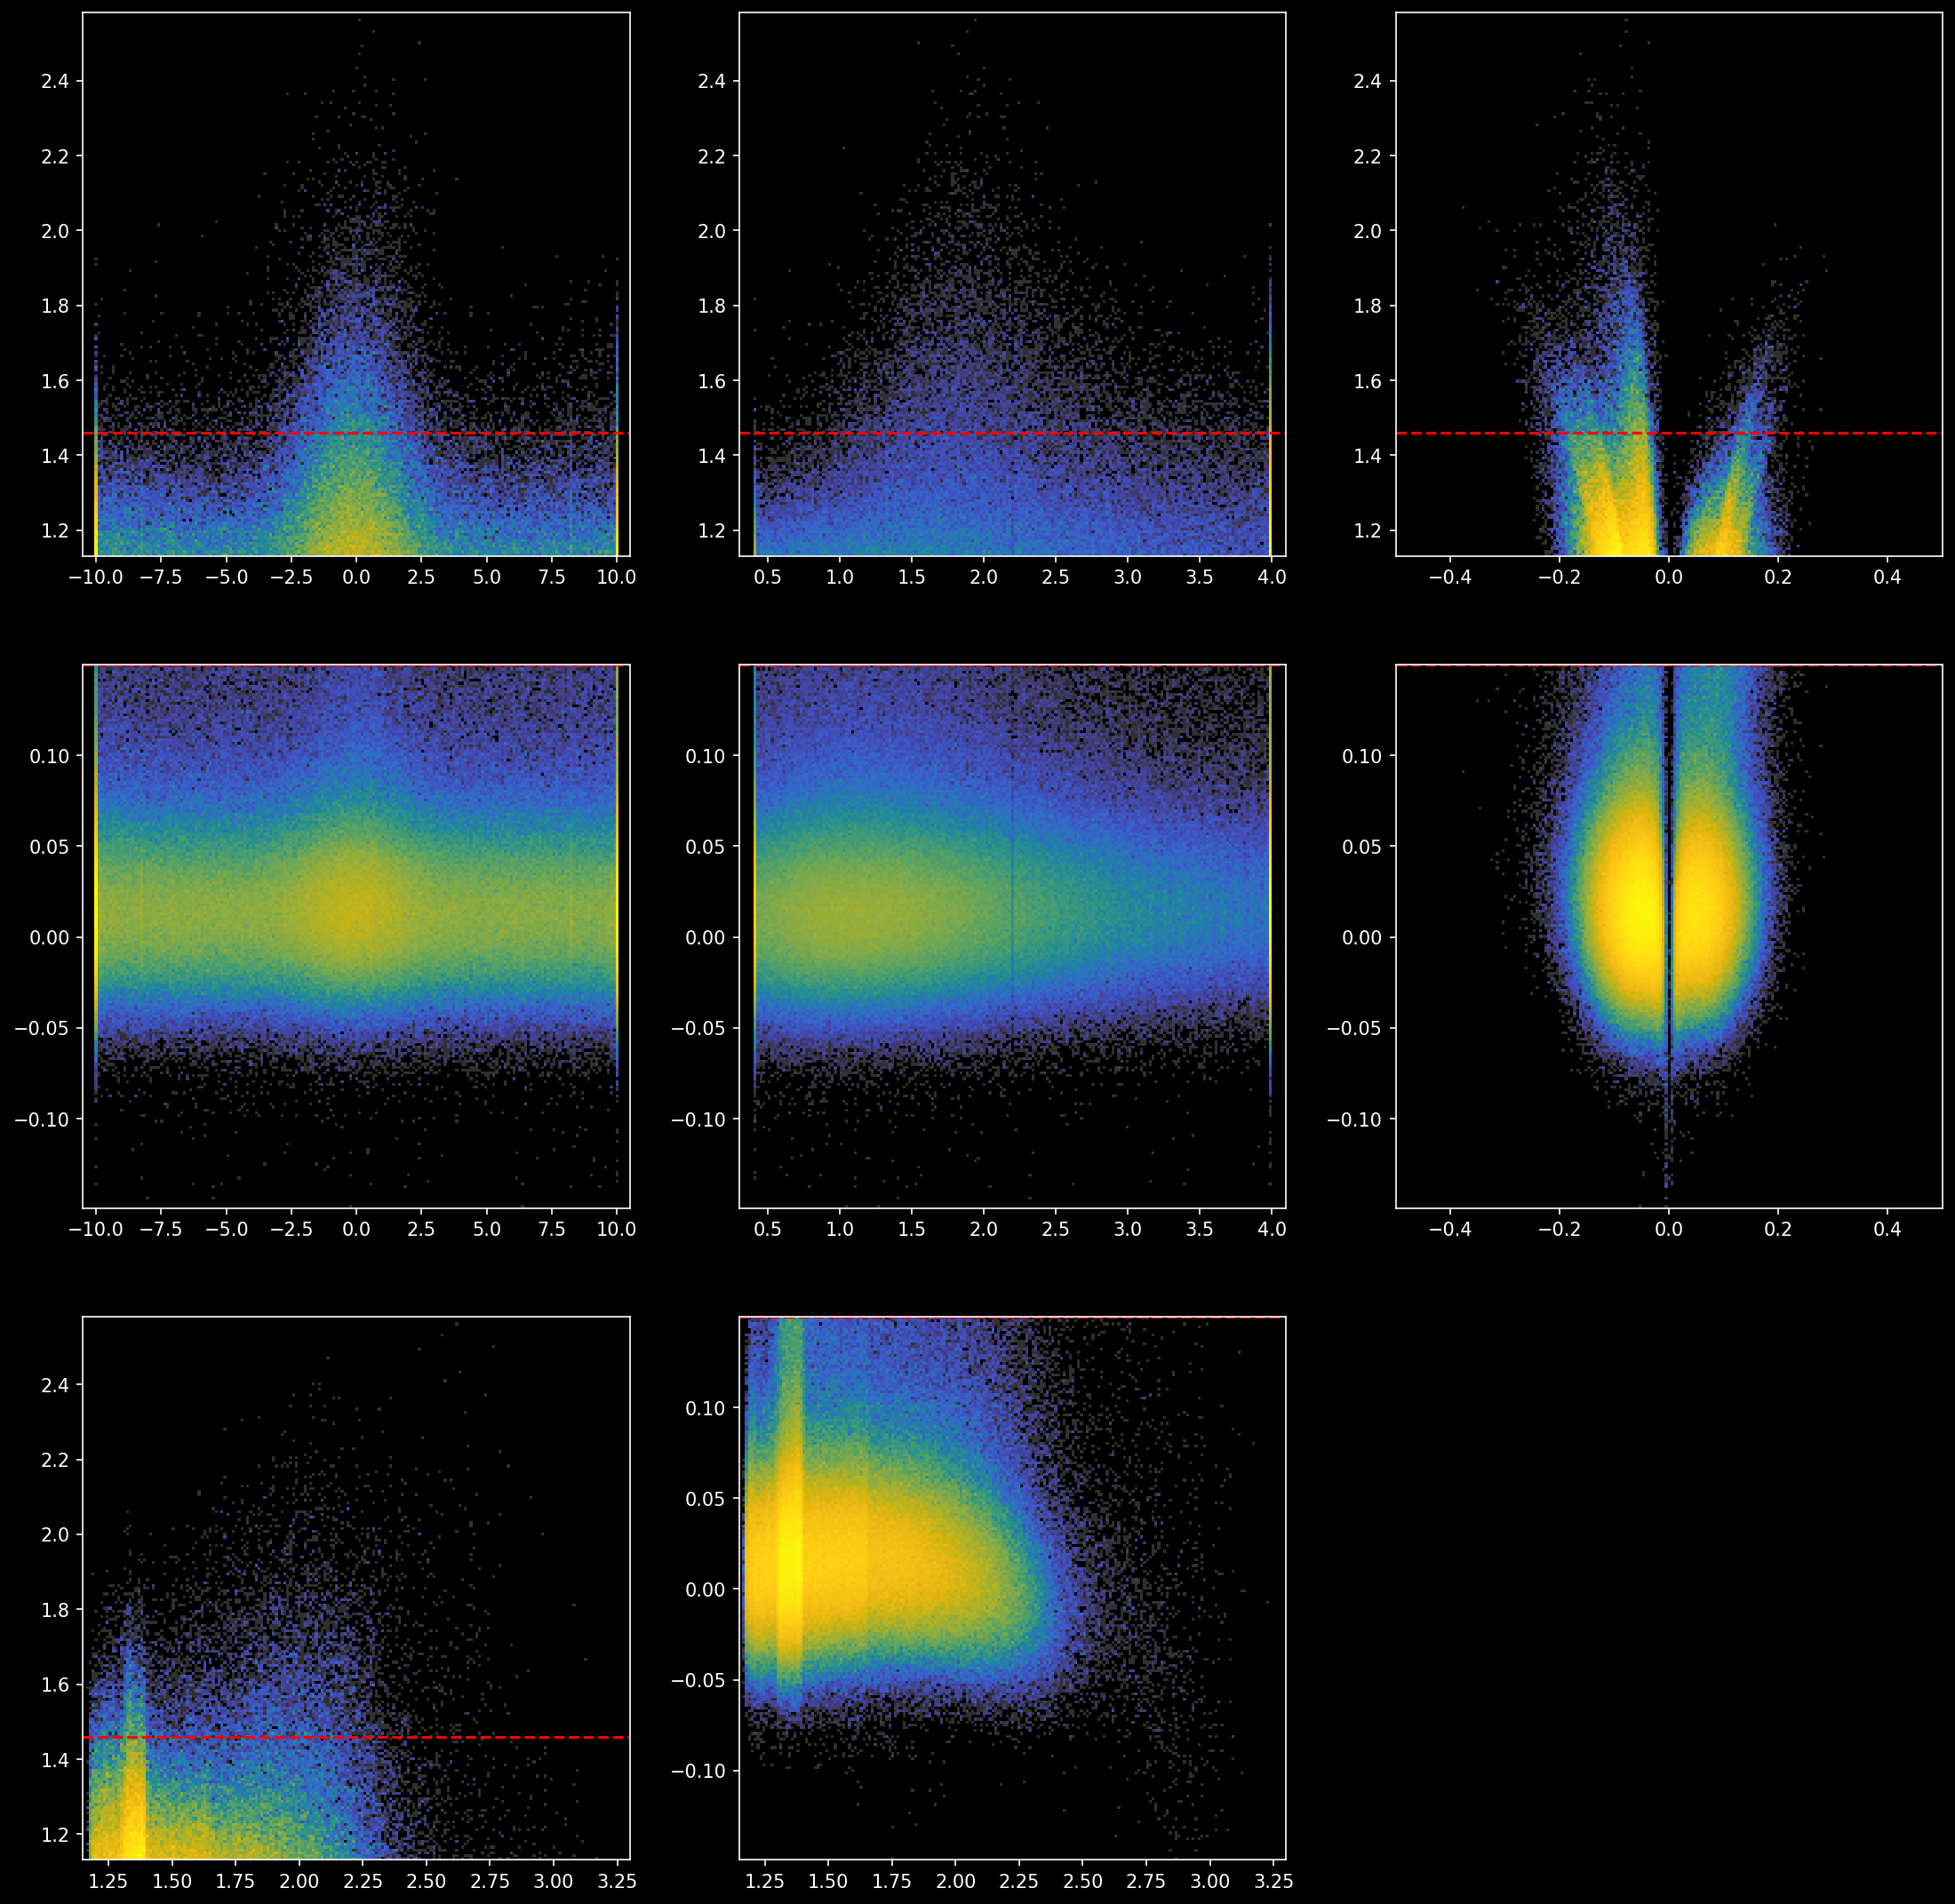

PyObject <matplotlib.lines.Line2D object at 0x14a6e0af0f10>

In [38]:
delthres = 1.46

mint = minimum(filter(.!isnan,log10.(-sout_mat[9,msk5])))
maxt = maximum(filter(.!isnan,log10.(-sout_mat[9,msk5])))

fig = plt.figure(figsize=(18,18),dpi=150)
nbin = 191
ax = fig.add_subplot(3,3,1)
ax.hist2d(
    (-0.1 .*sout_mat[11,msk5]),
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,2)
ax.hist2d(
    sout_mat[12,msk5],
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,3)
ax.hist2d(
    t_out[1,msk5],
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    cmap="cet_gouldian",
    range=((-0.5,0.5),(mint,maxt)),
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

chi2perdof  = 0.15

mint1 = minimum(filter(.!isnan,(log10.(noisefact*sout_mat[15,msk5]./count(star_msk)))))
maxt1 = maximum(filter(.!isnan,(log10.(noisefact*sout_mat[15,msk5]./count(star_msk)))))

ax = fig.add_subplot(3,3,4)
ax.hist2d(
    (-0.1 .*sout_mat[11,msk5]),
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,5)
ax.hist2d(
    sout_mat[12,msk5],
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,6)
ax.hist2d(
    t_out[1,msk5],
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-0.5,0.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")


ax = fig.add_subplot(3,3,7)
ax.hist2d(
    log10.(SNR_lst[msk5]),
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,8)
ax.hist2d(
    log10.(SNR_lst[msk5]),
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

In [39]:
msk5 = (sout_mat[12,:].>=sigrng[21]) .& (sout_mat[12,:].!=sigrng[end-10])
msk5 .&= (sigrng[11] .<= t_out[3,:].<= sigrng[end-10])

msk5 .&= (srng[11] .< sout_mat[11,:].<srng[end-10])
msk5 .&= (srng[11] .< 10*(t_out[2,:].-mu1).<srng[end-10])

msk5 .&= .!isnan.(sout_mat[19,:]);

msk5 .&= (-chi2perdof .< (log10.(noisefact*sout_mat[15,:]./count(star_msk))).<chi2perdof)
count(msk5), count(msk5)/length(msk5)

(562661, 0.5628608155895343)

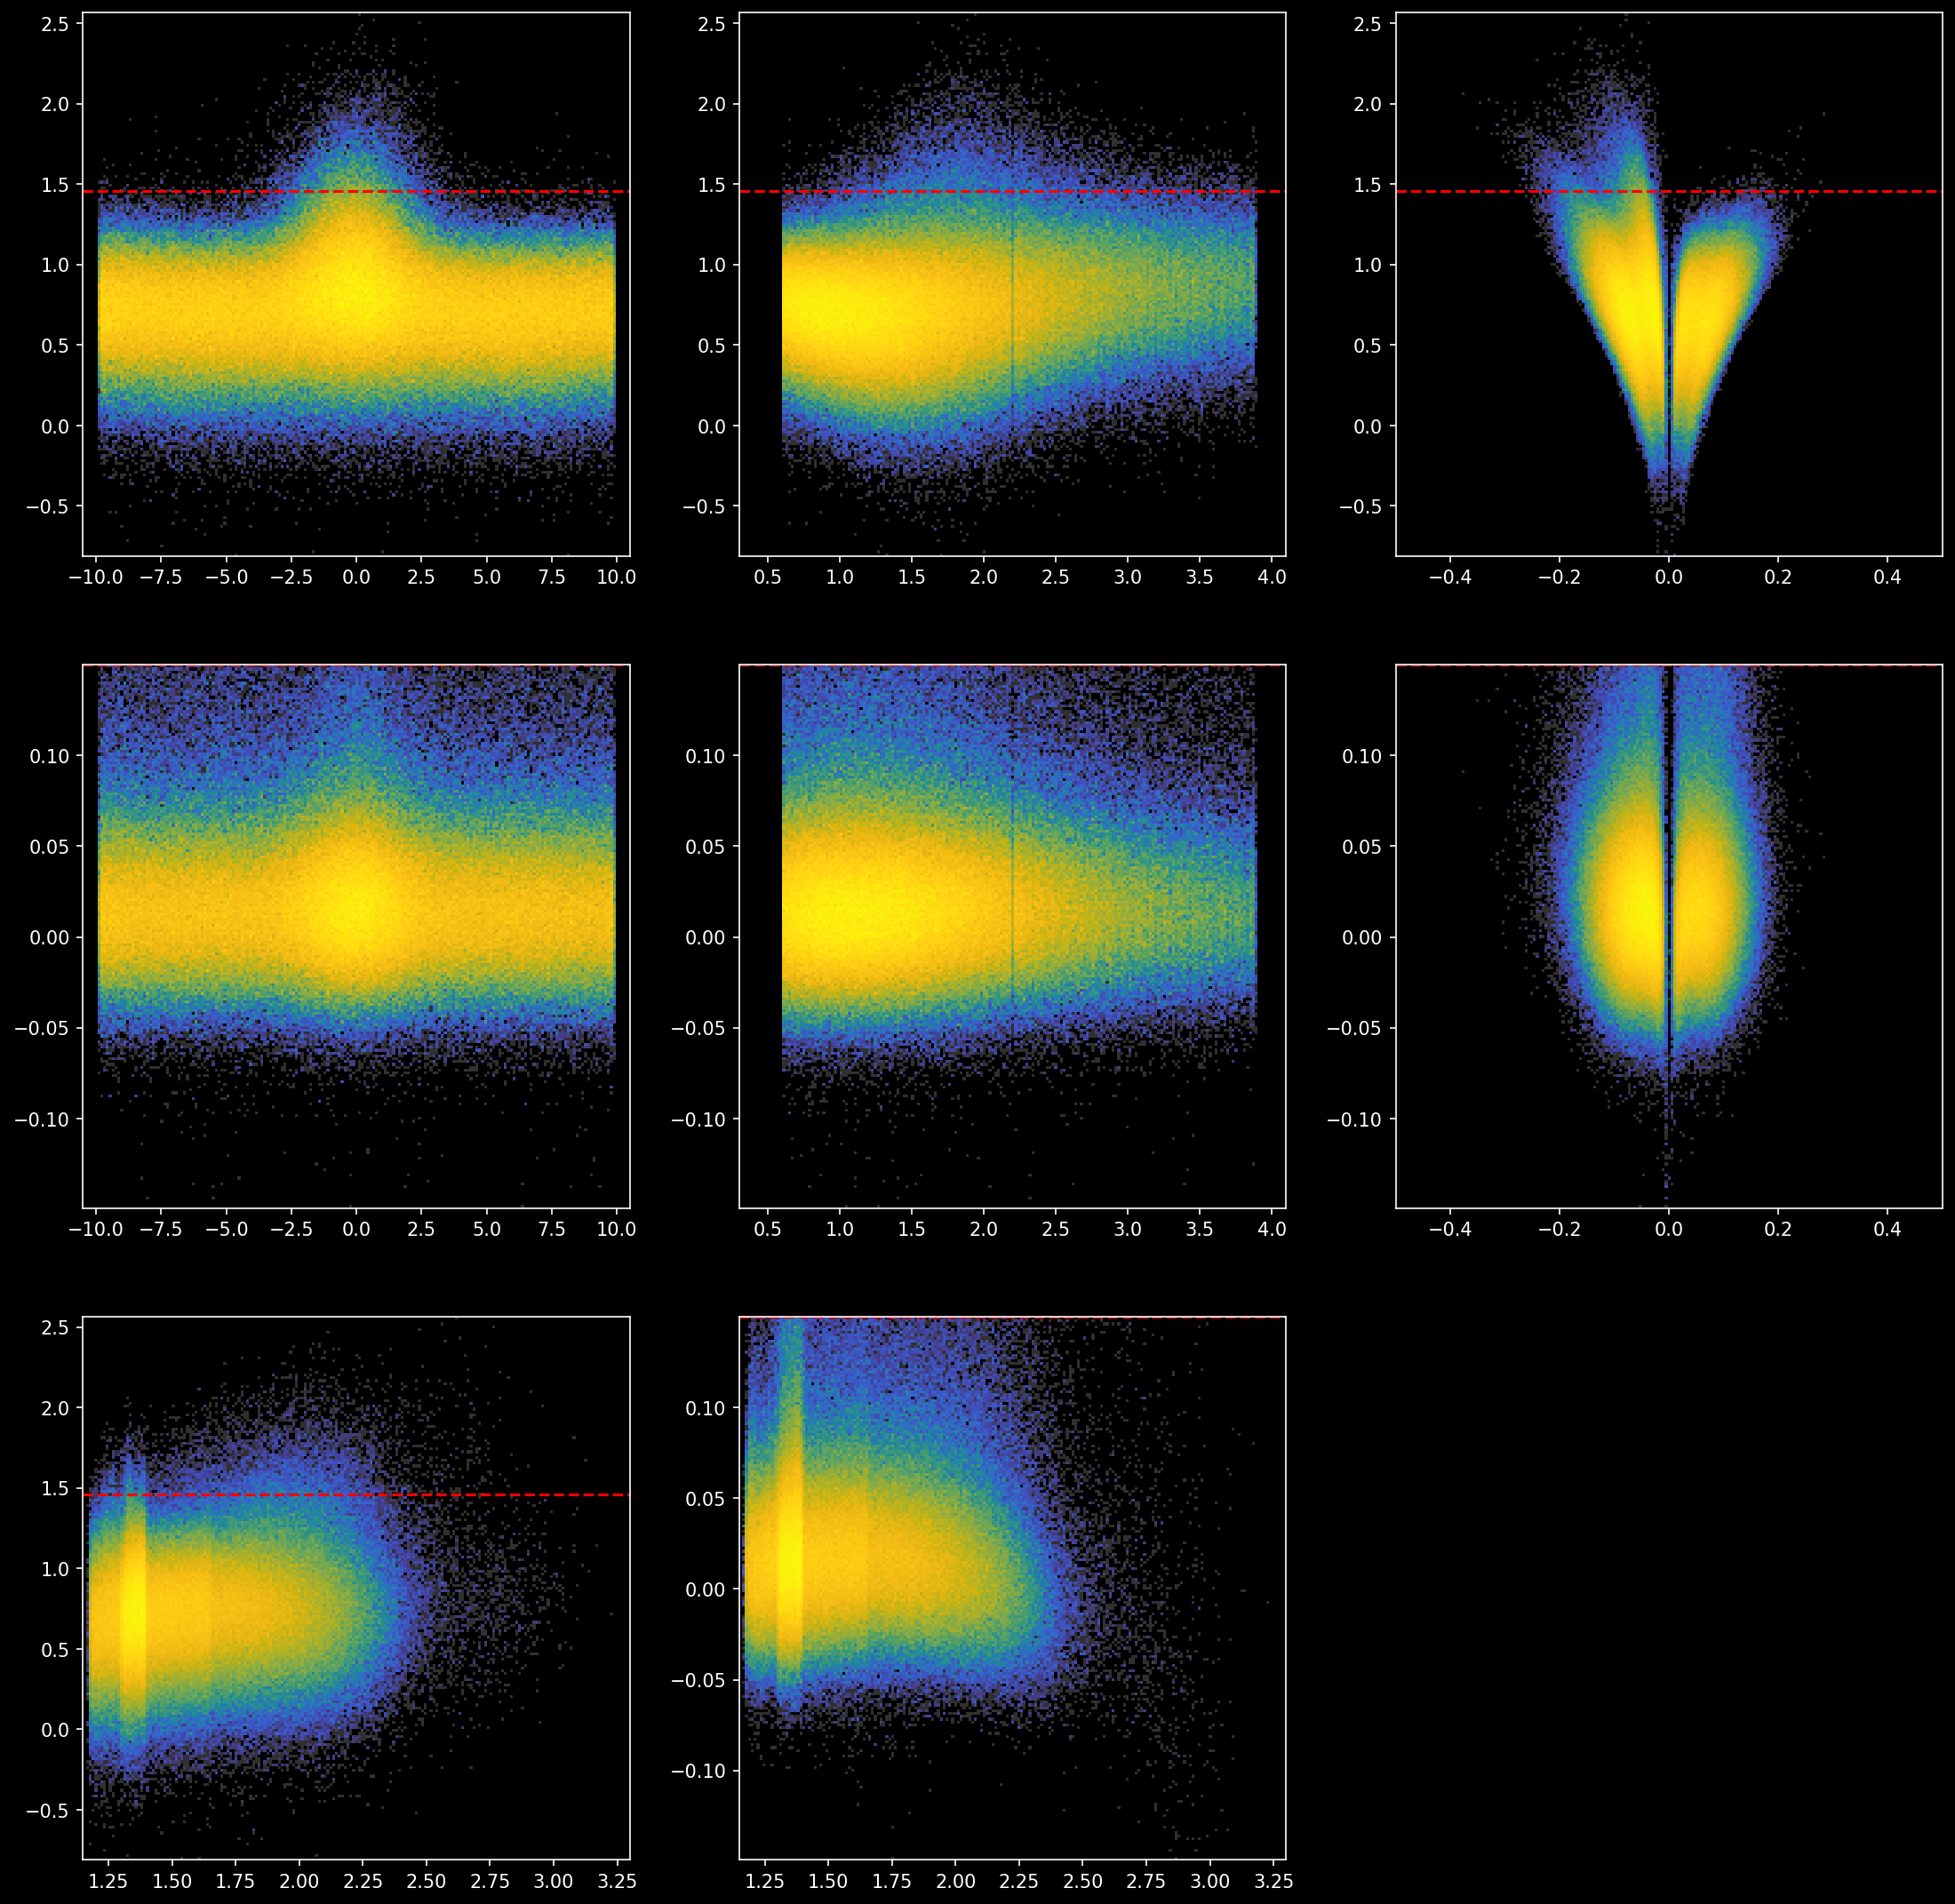

PyObject <matplotlib.lines.Line2D object at 0x14a6e085e6a0>

In [40]:
delthres = 1.46

mint = minimum(filter(.!isnan,log10.(-sout_mat[9,msk5].+covdet0)))
maxt = maximum(filter(.!isnan,log10.(-sout_mat[9,msk5].+covdet0)))

fig = plt.figure(figsize=(18,18),dpi=150)
nbin = 191
ax = fig.add_subplot(3,3,1)
ax.hist2d(
    (-0.1 .*sout_mat[11,msk5]),
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,2)
ax.hist2d(
    sout_mat[12,msk5],
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,3)
ax.hist2d(
    t_out[1,msk5],
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    cmap="cet_gouldian",
    range=((-0.5,0.5),(mint,maxt)),
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

chi2perdof  = 0.15

mint1 = minimum(filter(.!isnan,(log10.(noisefact*sout_mat[15,msk5]./count(star_msk)))))
maxt1 = maximum(filter(.!isnan,(log10.(noisefact*sout_mat[15,msk5]./count(star_msk)))))

ax = fig.add_subplot(3,3,4)
ax.hist2d(
    (-0.1 .*sout_mat[11,msk5]),
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-10.5,10.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,5)
ax.hist2d(
    sout_mat[12,msk5],
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((0.3,4.1),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

ax = fig.add_subplot(3,3,6)
ax.hist2d(
    t_out[1,msk5],
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((-0.5,0.5),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")


ax = fig.add_subplot(3,3,7)
ax.hist2d(
    log10.(SNR_lst[msk5]),
    log10.(-sout_mat[9,msk5].+covdet0),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint,maxt)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(delthres,color="red",linestyle="--")

ax = fig.add_subplot(3,3,8)
ax.hist2d(
    log10.(SNR_lst[msk5]),
    (log10.(noisefact*sout_mat[15,msk5]./count(star_msk))),
    bins=(nbin,nbin),
    range=((1.15,3.3),(mint1,maxt1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.axhline(chi2perdof,color="red",linestyle="--")
ax.axhline(-chi2perdof,color="red",linestyle="--")

In [15]:
msk5 = (sout_mat[12,:].>=sigrng[11]) .& (sout_mat[12,:].!=sigrng[end-10])
msk5 .&= (sigrng[11] .<= t_out[3,:].<= sigrng[end-10])

msk5 .&= (srng[11] .< sout_mat[11,:].<srng[end-10])
msk5 .&= (srng[11] .< 10*(t_out[2,:].-mu1).<srng[end-10])

msk5 .&= .!isnan.(sout_mat[19,:]);

msk5 .&= (-chi2perdof .< (log10.(noisefact*sout_mat[15,:]./count(star_msk))).<chi2perdof)
msk5 .&= (log10.(-sout_mat[9,:].+covdet0).>delthres)
count(msk5), count(msk5)/length(msk5)

(7789, 0.00779176607695732)

In [16]:
dwav = 51
lsqmsk = (cgrid-dwav) .<wavex .<(cgrid+dwav);
dwav=40
minlsqmsk = minimum(wavex[lsqmsk])
maxlsqmsk = maximum(wavex[lsqmsk]);

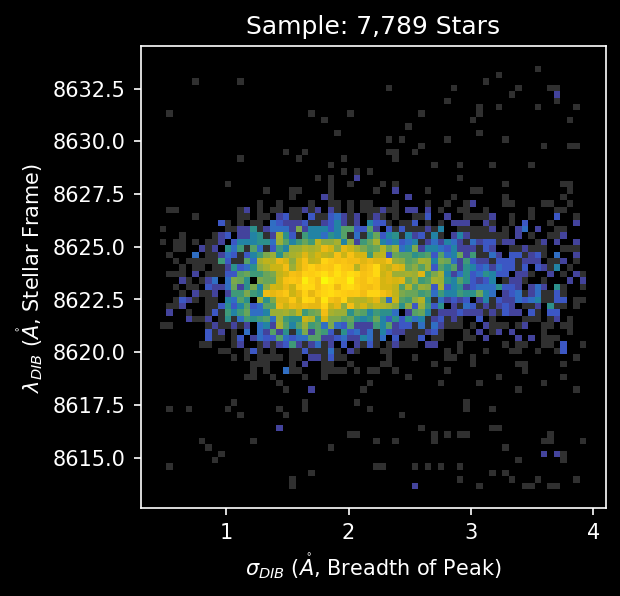

In [17]:
fig = plt.figure(figsize=(4,4),dpi=150)
plt.subplots_adjust(wspace=0.55, 
                    hspace=0.4)
cnts = count(msk5)

nbin=72

ax = fig.add_subplot(1,1,1)

img = ax.hist2d(t_out[3,msk5],abs.(t_out[2,msk5]),
    bins=(nbin,nbin),
    range=((0.3,4.1),(minimum(wavex[lsqmsk])+40,maximum(wavex[lsqmsk])-40)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
)

ax.set_title("Sample: "*format(cnts, commas=true)*" Stars")
ax.set_ylabel(L"$\lambda_{DIB}$ ($\mathring{A}$, Stellar Frame)")
ax.set_xlabel(L"$\sigma_{DIB}$ ($\mathring{A}$, Breadth of Peak)")

ax.set_ylim(minimum(wavex[lsqmsk])+40,maximum(wavex[lsqmsk])-40)
ax.set_xlim(0.3,4.1);

In [18]:
count(t_out[1,msk5].>0)

94

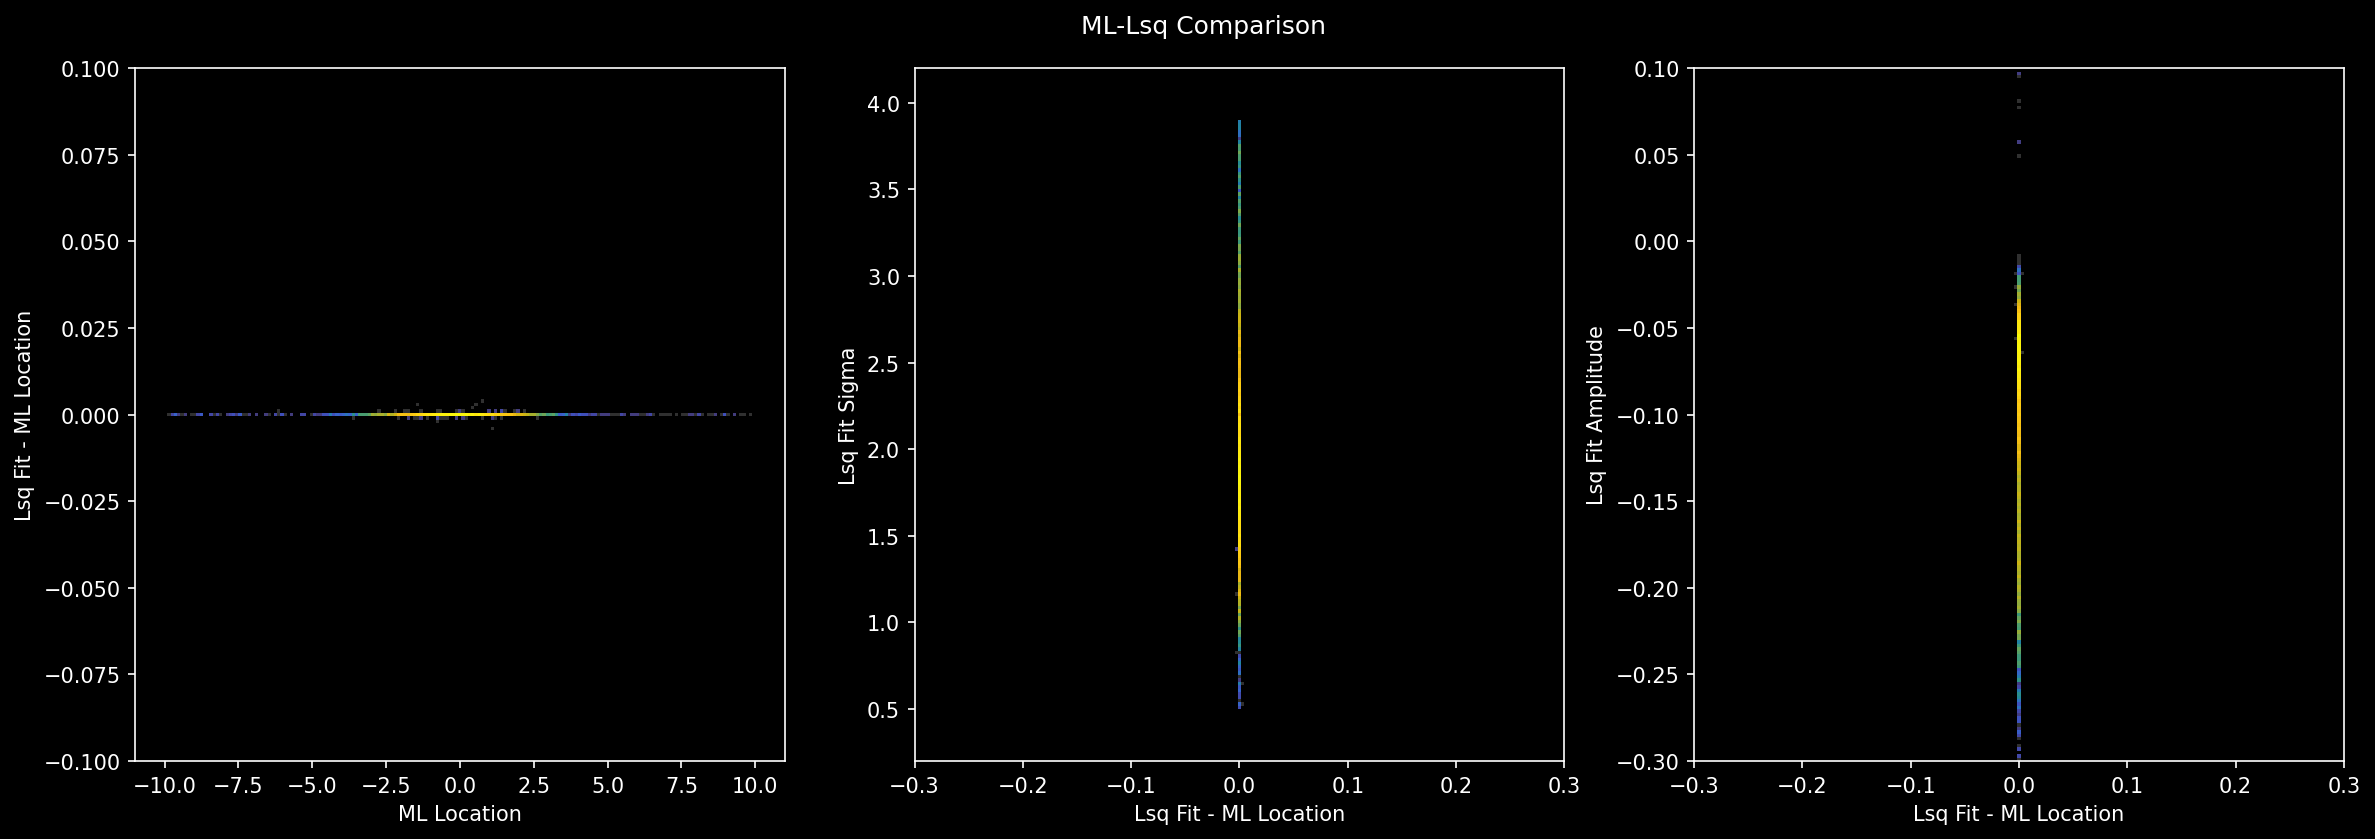

In [19]:
fig = plt.figure(figsize=(19,6),dpi=150)
plt.suptitle("ML-Lsq Comparison",y=0.94)
dwav=11
ax = fig.add_subplot(1,3,1)
nbin=201
ax.hist2d(-0.1 .*sout_mat[11,msk5],
    t_out[2,msk5].-(mu1.-0.1 .*sout_mat[11,msk5]),
    bins=(nbin,nbin),
    range=((-dwav,dwav),(-0.1,0.1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-dwav,dwav)
ax.set_ylim(-0.1,0.1)
dwav=40

ax.set_xlabel("ML Location")
ax.set_ylabel("Lsq Fit - ML Location")


ax = fig.add_subplot(1,3,2)
nbin=201
ax.hist2d(mu1.-0.1 .*sout_mat[11,msk5].-t_out[2,msk5],t_out[3,msk5],
    bins=(nbin,nbin),
    range=((-0.3,0.3),(0.2,4.2)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-0.3,0.3)
ax.set_ylim(0.2,4.2)

ax.set_ylabel("Lsq Fit Sigma")
ax.set_xlabel("Lsq Fit - ML Location")


ax = fig.add_subplot(1,3,3)
nbin=201
ax.hist2d(mu1.-0.1 .*sout_mat[11,msk5].-t_out[2,msk5],t_out[1,msk5],
    bins=(nbin,nbin),
    range=((-0.3,0.3),(-0.3,0.1)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.1)

ax.set_ylabel("Lsq Fit Amplitude")
ax.set_xlabel("Lsq Fit - ML Location");

In [20]:
minor = Int.(mod1.(10*sout_mat[11,:] .+6,10))
major = Int.(fld1.(10*sout_mat[11,:] .+6,10).-1);

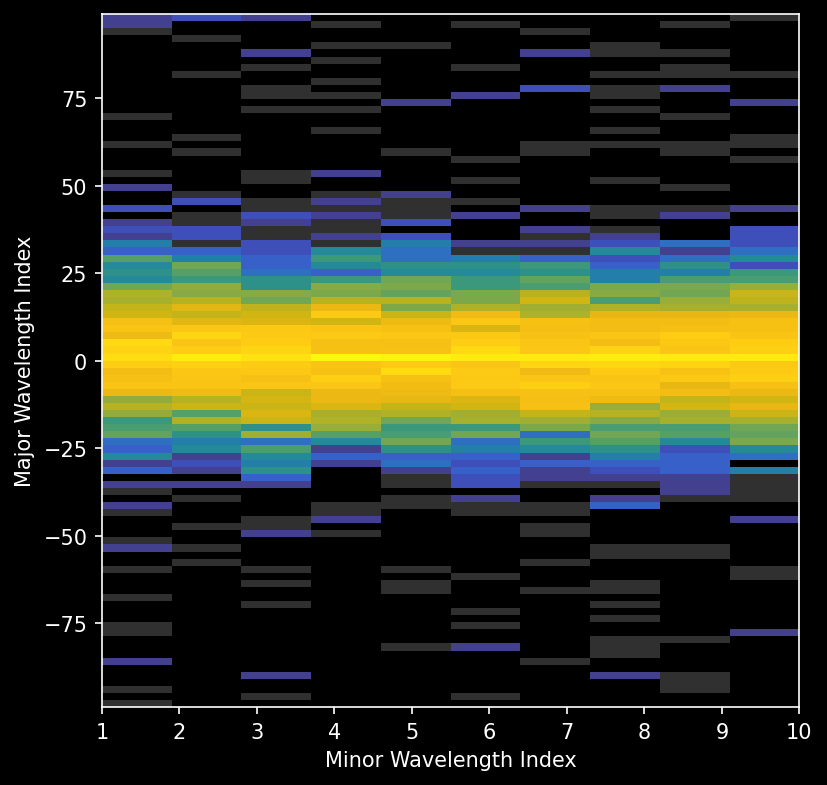

PyObject Text(35.00000000000001, 0.5, 'Major Wavelength Index')

In [21]:
fig = plt.figure(figsize=(6,6),dpi=150)
nbin = 101
ax = fig.add_subplot(1,1,1)
ax.hist2d(
    minor[msk5],
    major[msk5],
    bins=(10,98),
    range=((1,10),(-99,99)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_xlabel("Minor Wavelength Index")
ax.set_ylabel("Major Wavelength Index")

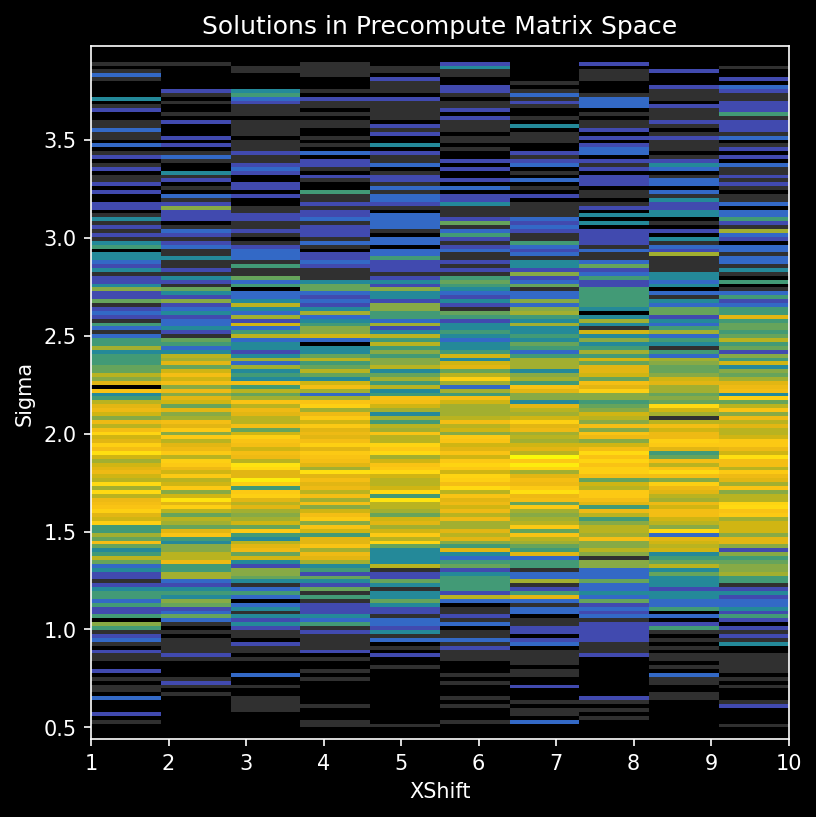

PyObject Text(35.00000000000001, 0.5, 'Sigma')

In [22]:
fig = plt.figure(figsize=(6,6),dpi=150)
nbin = 101
ax = fig.add_subplot(1,1,1)
ax.hist2d(
    minor[msk5],
    sout_mat[12,msk5],
    bins=(10,178),
    range=((1,10),(0.44,3.98)),
    cmap="cet_gouldian",
    norm=mplcolors.LogNorm()
);

ax.set_title("Solutions in Precompute Matrix Space")

ax.set_xlabel("XShift")
ax.set_ylabel("Sigma")

# Export New

In [23]:
grvs = h5open("../sources/gaia_rvs_lite.h5");

In [24]:
#These are all a permutation off of my sorted ordering

#GSPSPEC_Results
f = FITS("../gaia_archive_results/RVS_astro-result.fits.gz")
astro_source_id = read(f[2],"source_id")
dibp0_gspspec = read(f[2],"dibp0_gspspec")

dib_gspspec_lambda = read(f[2],"dib_gspspec_lambda")
dib_gspspec_lambda_uncertainty = read(f[2],"dib_gspspec_lambda_uncertainty")

dibew_gspspec = read(f[2],"dibew_gspspec")
dibew_gspspec_uncertainty = read(f[2],"dibew_gspspec_uncertainty")
dibewnoise_gspspec_uncertainty = read(f[2],"dibewnoise_gspspec_uncertainty");

dibp2_gspspec = read(f[2],"dibp2_gspspec")
dibp2_gspspec_uncertainty = read(f[2],"dibp2_gspspec_uncertainty");

dibqf_gspspec = read(f[2],"dibqf_gspspec");
flags_gspspec = read(f[2],"flags_gspspec");
logchisq_gspspec = read(f[2],"logchisq_gspspec");
close(f)

#CBJ_Results
f = FITS("../gaia_archive_results/CBJ_distances-result.fits.gz")
source_id_cbj = read(f[2],"source_id");
r_med_geo_cbj = read(f[2],"r_med_geo");
r_lo_geo_cbj = read(f[2],"r_lo_geo");
r_hi_geo_cbj = read(f[2],"r_hi_geo");
r_med_photogeo_cbj = read(f[2],"r_med_photogeo");
r_lo_photogeo_cbj = read(f[2],"r_lo_photogeo");
r_hi_photogeo_cbj = read(f[2],"r_hi_photogeo");
flag_cbj = read(f[2],"flag");
close(f)

#General_Gaia_Results
f = FITS("../gaia_archive_results/RVS_source-result.fits.gz")
RVS_source_id = read(f[2],"source_id")
ra = read(f[2],"ra")
dec = read(f[2],"dec")
parallax = read(f[2],"parallax");
parallax_err = read(f[2],"parallax_error");
vbary = read(f[2],"radial_velocity");
vbary_err = read(f[2],"radial_velocity_error");
ebpminrp_gspphot = read(f[2],"ebpminrp_gspphot")
close(f)

ps = sortperm(RVS_source_id);

In [25]:
grvs_id = read(grvs["SOURCE_ID"]);
glon = read(grvs["GLON"]);
glat = read(grvs["GLAT"]);

In [26]:
grvs_id == astro_source_id[ps], grvs_id == source_id_cbj[ps], grvs_id == RVS_source_id[ps]

(true, true, true)

In [27]:
msk = nansum .& msk5;

In [28]:
U = cosd.(glon).*cosd.(glat)
V = sind.(glon).*cosd.(glat)
W = sind.(glat)

dkpc = r_med_geo_cbj[ps]./1000
GX = dkpc.*U
GY = dkpc.*V
GZ = dkpc.*W;

In [29]:
c = 299792.458; # in km/s
cwave = 8623.14
Cobs = (1 .+ vbary[ps]./c).*t_out[2,:]
vd_bary = (Cobs .- cwave)./ Cobs .* c;

function project_VLSR(u,v,w; rGVLSR = (10.6,10.7,7.6))
    return dot(rGVLSR,[u,v,w])
end

voff = project_VLSR.(U,V,W);

In [30]:
using SkyCoords
c1 = FK5Coords{1900}(1.5*π,π/6)
c2 = convert(GalCoords, c1)
DameX = 20*cos(c2.l)*cos(c2.b)
DameY = 20*sin(c2.l)*cos(c2.b)
DameZ = 20*sin(c2.b)

function project_VLSR_df(u,v,w; rGVLSR = (DameX,DameY,DameZ))
    return dot(rGVLSR,[u,v,w])
end

voff_df = project_VLSR_df.(U,V,W);

In [31]:
vlsr = vd_bary .+ voff;
vlsr_df = vd_bary .+ voff_df;

In [32]:
ew_est = t_out[1,:].*t_out[3,:]
ew_err = sout_mat[22,:]

lam_est = t_out[2,:]
lam_err = sout_mat[19,:]

sig_est = t_out[3,:]
sig_err = sout_mat[20,:]

vlsr_err = cwave*c./(1 .+ vbary[ps]./c)./(lam_est.^2).*lam_err;

In [33]:
glonm = glon[msk]
glatm = glat[msk]
d_kpcm = dkpc[msk]
reddeningvec = zero(glonm);
fill!(reddeningvec,NaN)
mskt = d_kpcm .>0

glonmt = glonm[mskt]
glatmt = glatm[mskt]
d_kpcmt = d_kpcm[mskt];

In [34]:
py"""

from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarWebQuery

bayestar = BayestarWebQuery(version='bayestar2019')

l = $glonmt
b = $glatmt
d = $d_kpcmt

coords = SkyCoord(l*units.deg, b*units.deg, distance=d*units.kpc, frame='galactic')
reddening = bayestar(coords, mode='median')

"""

bred = 1 .* py"reddening";
reddeningvec[mskt].=bred;
println(count(isnan.(reddeningvec)))

py"""

from dustmaps.sfd import SFDWebQuery

sfd = SFDWebQuery()

l = $glonm
b = $glatm

coords = SkyCoord(l*units.deg, b*units.deg, frame='galactic')
sfd_reddening = sfd(coords)

"""

sfd_red = 1 .* py"sfd_reddening";

2436


In [69]:
fname = "../dib_explore_v14.h5"

# My Catalog
h5write(fname, "ew", -ew_est[msk])
h5write(fname, "ew_err", ew_err[msk])

h5write(fname, "lam", lam_est[msk])
h5write(fname, "lam_err", lam_err[msk])

h5write(fname, "sig", sig_est[msk])
h5write(fname, "sig_err", sig_err[msk])

h5write(fname, "v_dust_lsr", vlsr[msk])
h5write(fname, "v_dust_lsr_COframe", vlsr_df[msk])
h5write(fname, "v_dust_lsr_err", vlsr_err[msk])

h5write(fname, "log10delchisq", log10.(-sout_mat[9,msk]))
h5write(fname, "dib_snr", sqrt.(0.5 .* (-sout_mat[9,msk].+covdet0)))
h5write(fname, "totchisqperdof", noisefact.*sout_mat[13,msk]./count(star_msk))

# Gaia Info
h5write(fname, "gaia_source_id",grvs_id[msk])
h5write(fname, "linear_indx",(1:length(grvs_id))[msk])
h5write(fname, "stellar_snr",SNR_lst[msk])

h5write(fname, "ra", ra[ps][msk])
h5write(fname, "dec", dec[ps][msk])

h5write(fname, "glon", glon[msk])
h5write(fname, "glat", glat[msk])

h5write(fname, "X", GX[msk])
h5write(fname, "Y", GY[msk])
h5write(fname, "Z", GZ[msk])

h5write(fname, "U", U[msk])
h5write(fname, "V", V[msk])
h5write(fname, "W", W[msk])

h5write(fname, "parallax", parallax[ps][msk])
h5write(fname, "parallax_error", parallax_err[ps][msk])
h5write(fname, "v_star_bary", vbary[ps][msk])
h5write(fname, "v_star_bary_error", vbary_err[ps][msk])
h5write(fname, "ebpminrp_gspphot", ebpminrp_gspphot[ps][msk])

# Meta Info
h5write(fname, "sfd", sfd_red)
h5write(fname, "bayestar19", reddeningvec)

#Gaia Catalog
h5write(fname, "dib_gspspec_lambda", dib_gspspec_lambda[ps][msk])
h5write(fname, "dib_gspspec_lambda_uncertainty", dib_gspspec_lambda_uncertainty[ps][msk])
h5write(fname, "dibew_gspspec", dibew_gspspec[ps][msk])
h5write(fname, "dibew_gspspec_uncertainty", dibew_gspspec_uncertainty[ps][msk])
h5write(fname, "dibewnoise_gspspec_uncertainty", dibewnoise_gspspec_uncertainty[ps][msk])
h5write(fname, "dibp0_gspspec", dibp0_gspspec[ps][msk])
h5write(fname, "dibp2_gspspec", dibp2_gspspec[ps][msk])
h5write(fname, "dibp2_gspspec_uncertainty", dibp2_gspspec_uncertainty[ps][msk])
h5write(fname, "dibqf_gspspec", dibqf_gspspec[ps][msk])
h5write(fname, "logchisq_gspspec", logchisq_gspspec[ps][msk])
h5write(fname, "flags_gspspec", flags_gspspec[ps][msk])
    
#CBJ Catalog
h5write(fname, "r_med_geo", r_med_geo_cbj[ps][msk])
h5write(fname, "r_lo_geo", r_lo_geo_cbj[ps][msk])
h5write(fname, "r_hi_geo", r_hi_geo_cbj[ps][msk])
h5write(fname, "r_med_photogeo", r_med_photogeo_cbj[ps][msk])
h5write(fname, "r_lo_photogeo", r_lo_photogeo_cbj[ps][msk])
h5write(fname, "r_hi_photogeo", r_hi_photogeo_cbj[ps][msk])
h5write(fname, "flag_cbj", flag_cbj[ps][msk]);

In [35]:
msk5 = (sout_mat[12,:].>=sigrng[11]) .& (sout_mat[12,:].!=sigrng[end-10])
msk5 .&= (sigrng[11] .<= t_out[3,:].<= sigrng[end-10])

msk5 .&= (srng[11] .< sout_mat[11,:].<srng[end-10])
msk5 .&= (srng[11] .< 10*(t_out[2,:].-mu1).<srng[end-10])

msk5 .&= .!isnan.(sout_mat[19,:]);

# msk5 .&= (-chi2perdof .< (log10.(noisefact*sout_mat[15,:]./count(star_msk))).<chi2perdof)
msk5 .&= (log10.(-sout_mat[9,:].+covdet0).>delthres)
count(msk5), count(msk5)/length(msk5)

(19071, 0.019077772609276292)

In [36]:
msk = nansum .& msk5;

In [72]:
fname = "../support/dib_explore_v14_nototchi2.h5"

# My Catalog
h5write(fname, "ew", -ew_est[msk])
h5write(fname, "ew_err", ew_err[msk])

h5write(fname, "lam", lam_est[msk])
h5write(fname, "lam_err", lam_err[msk])

h5write(fname, "sig", sig_est[msk])
h5write(fname, "sig_err", sig_err[msk])

h5write(fname, "v_dust_lsr", vlsr[msk])
h5write(fname, "v_dust_lsr_COframe", vlsr_df[msk])
h5write(fname, "v_dust_lsr_err", vlsr_err[msk])

h5write(fname, "log10delchisq", log10.(-sout_mat[9,msk]))
h5write(fname, "dib_snr", sqrt.(0.5 .* (-sout_mat[9,msk].+covdet0)))
h5write(fname, "totchisqperdof", noisefact.*sout_mat[13,msk]./count(star_msk))

# Gaia Info
h5write(fname, "gaia_source_id",grvs_id[msk])
h5write(fname, "linear_indx",(1:length(grvs_id))[msk])
h5write(fname, "stellar_snr",SNR_lst[msk])

h5write(fname, "ra", ra[ps][msk])
h5write(fname, "dec", dec[ps][msk])

h5write(fname, "glon", glon[msk])
h5write(fname, "glat", glat[msk])

h5write(fname, "X", GX[msk])
h5write(fname, "Y", GY[msk])
h5write(fname, "Z", GZ[msk])

h5write(fname, "U", U[msk])
h5write(fname, "V", V[msk])
h5write(fname, "W", W[msk])

h5write(fname, "parallax", parallax[ps][msk])
h5write(fname, "parallax_error", parallax_err[ps][msk])
h5write(fname, "v_star_bary", vbary[ps][msk])
h5write(fname, "v_star_bary_error", vbary_err[ps][msk])
h5write(fname, "ebpminrp_gspphot", ebpminrp_gspphot[ps][msk])

# Meta Info
h5write(fname, "sfd", sfd_red)
h5write(fname, "bayestar19", reddeningvec)

#Gaia Catalog
h5write(fname, "dib_gspspec_lambda", dib_gspspec_lambda[ps][msk])
h5write(fname, "dib_gspspec_lambda_uncertainty", dib_gspspec_lambda_uncertainty[ps][msk])
h5write(fname, "dibew_gspspec", dibew_gspspec[ps][msk])
h5write(fname, "dibew_gspspec_uncertainty", dibew_gspspec_uncertainty[ps][msk])
h5write(fname, "dibewnoise_gspspec_uncertainty", dibewnoise_gspspec_uncertainty[ps][msk])
h5write(fname, "dibp0_gspspec", dibp0_gspspec[ps][msk])
h5write(fname, "dibp2_gspspec", dibp2_gspspec[ps][msk])
h5write(fname, "dibp2_gspspec_uncertainty", dibp2_gspspec_uncertainty[ps][msk])
h5write(fname, "dibqf_gspspec", dibqf_gspspec[ps][msk])
h5write(fname, "logchisq_gspspec", logchisq_gspspec[ps][msk])
h5write(fname, "flags_gspspec", flags_gspspec[ps][msk])
    
#CBJ Catalog
h5write(fname, "r_med_geo", r_med_geo_cbj[ps][msk])
h5write(fname, "r_lo_geo", r_lo_geo_cbj[ps][msk])
h5write(fname, "r_hi_geo", r_hi_geo_cbj[ps][msk])
h5write(fname, "r_med_photogeo", r_med_photogeo_cbj[ps][msk])
h5write(fname, "r_lo_photogeo", r_lo_photogeo_cbj[ps][msk])
h5write(fname, "r_hi_photogeo", r_hi_photogeo_cbj[ps][msk])
h5write(fname, "flag_cbj", flag_cbj[ps][msk]);